Plot alpha diversity startified for PPI and abx in combination

Input file: shannon_dv.txt (alpha diversity), Demographic_table1.xlsx


In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from matplotlib import transforms, lines, figure
import matplotlib.transforms as mtransforms
from matplotlib.font_manager import FontProperties
from seaborn.utils import remove_na
import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Arial"

In [2]:
def setLT_alpha(row):
    """
    Make a column with 'No', 'Yes' which is an snswer to the question 'Did the patient had a lung transplant?'.
    Takes row in DF as input and returns value depending on the row value. 
    """
    
    if row['Lung_Transplant'] == 'yes':
            
        return 'Lung Transplant'

    else:    
        return 'Other'

In [3]:
def setCondition_alpha(row):
    """
    Make a column with 'healthy', 'CF' or 'LT'. Takes row in DF as input and returns value depending on the row 
    value. 
    
    According to instructions; CF with a LT is classified as healthy.  
    """
    
    if row['Cystic_fibrosis'] == 'yes':
        
        if row['Lung_Transplant'] == 'yes':
            
            return 'Healthy'
        
        else:
            
            return 'Cystic Fibrosis'
        
    return 'Healthy'

In [4]:
### Code adapted from https://github.com/webermarcolivier/statannot ###

from matplotlib.text import Text
import matplotlib.pyplot as plt
from matplotlib import transforms, lines
import matplotlib.transforms as mtransforms
from matplotlib.font_manager import FontProperties
from seaborn.utils import remove_na

from scipy import stats
DEFAULT = object()


def stat_test(box_data1, box_data2, test):
    test_short_name = ''
    formatted_output = None
    if test == 'Wilcoxon':
        u_stat, pval = stats.ranksums(box_data1, box_data2)
        test_short_name = 'Wilcox'
        formatted_output = ("Wilcoxon test P_val={:.3e} U_stat={:.3e}"
                           .format(pval, u_stat))
    return pval, u_stat,formatted_output, test_short_name


def pval_annotation_text(x, pvalue_thresholds):
    singleValue = False
    if type(x) is np.array:
        x1 = x
    else:
        x1 = np.array([x])
        singleValue = True
    # Sort the threshold array
    pvalue_thresholds = pd.DataFrame(pvalue_thresholds).sort_values(by=0, ascending=False).values
    x_annot = pd.Series(["" for _ in range(len(x1))])
    for i in range(0, len(pvalue_thresholds)):
        if (i < len(pvalue_thresholds)-1):
            condition = (x1 <= pvalue_thresholds[i][0]) & (pvalue_thresholds[i+1][0] < x1)
            x_annot[condition] = pvalue_thresholds[i][1]
        else:
            condition = x1 < pvalue_thresholds[i][0]
            x_annot[condition] = pvalue_thresholds[i][1]

    return x_annot if not singleValue else x_annot.iloc[0]


def simple_text(pval, pvalue_format, pvalue_thresholds, test_short_name=None):
    """
    Generates simple text for test name and pvalue
    :param pval: pvalue
    :param pvalue_format: format string for pvalue
    :param test_short_name: Short name of test to show
    :param pvalue_thresholds: String to display per pvalue range
    :return: simple annotation
    """
    # Sort thresholds
    thresholds = sorted(pvalue_thresholds, key=lambda x: x[0])

    # Test name if passed
    text = test_short_name and test_short_name + " " or ""

    for threshold in thresholds:
        if pval < threshold[0]:
            pval_text = "p ≤ {}".format(threshold[1])
            break
    else:
        pval_text = "p = {}".format(pvalue_format).format(pval)

    #return text + pval_text
    return pval_text


def add_stat_annotation(ax,
                        data=None, x=None, y=None, hue=None, order=None, hue_order=None,
                        box_pairs=None,
                        test='t-test_welch', text_format='star', pvalue_format_string=DEFAULT,
                        loc='inside', show_test_name=True, pvalue_thresholds=DEFAULT,
                        use_fixed_offset=False, line_offset_to_box=None, line_offset=None,
                        line_height=0.02, text_offset=1, stack=True,
                        color='0.2', linewidth=1.5, fontsize='medium', verbose=1):
    """
    User should use the same argument for the data, x, y, hue, order, hue_order as the seaborn boxplot function.
    line_height is in axes fraction coordinates.
    text_offset is in points.
    box_pairs can be of either form:
    For non-grouped boxplot: [(cat1, cat2), (cat3, cat4)]
    For boxplot grouped by hue: [((cat1, hue1), (cat2, hue2)), ((cat3, hue3), (cat4, hue4))]
    Default pvalue_format_string is "{.3e}".
    pvalue_thresholds is a list of lists or tuples. Default is:
    For "star" text_format:
        [[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"], [1, "ns"]]
    For "simple" text_format :
        [[1e-5, "1e-5"], [1e-4, "1e-4"], [1e-3, "0.001"], [1e-2, "0.01"]]
    """

    def find_x_position_box(box_plotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        """
        if box_plotter.plot_hues is None:
            cat = boxName
            hueOffset = 0
        else:
            cat = boxName[0]
            hue = boxName[1]
            hueOffset = box_plotter.hue_offsets[box_plotter.hue_names.index(hue)]

        groupPos = box_plotter.group_names.index(cat)
        boxPos = groupPos + hueOffset
        return boxPos


    def get_box_data(box_plotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        Here we really have to duplicate seaborn code, because there is not direct access to the
        box_data in the BoxPlotter class.
        """
        if box_plotter.plot_hues is None:
            cat = boxName
        else:
            cat = boxName[0]
            hue = boxName[1]

        i = box_plotter.group_names.index(cat)
        group_data = box_plotter.plot_data[i]

        if box_plotter.plot_hues is None:
            # Draw a single box or a set of boxes
            # with a single level of grouping
            box_data = remove_na(group_data)
        else:
            hue_level = hue
            hue_mask = box_plotter.plot_hues[i] == hue_level
            box_data = remove_na(group_data[hue_mask])

        return box_data

    # Set default values if necessary
    if pvalue_format_string is DEFAULT:
        pvalue_format_string = '{:.3e}'
        simple_format_string = '{:.2f}'
    else:
        simple_format_string = pvalue_format_string

    if pvalue_thresholds is DEFAULT:
        if text_format == "star":
            pvalue_thresholds = [[1e-4, "****"], [1e-3, "***"],
                                 [1e-2, "**"], [0.05, "*"], [1, "ns"]]
        else:
            pvalue_thresholds = [[1e-5, "1e-5"], [1e-4, "1e-4"],
                                 [1e-3, "0.001"], [1e-2, "0.01"]]
    
    fig = plt.gcf()

    valid_list = ['inside', 'outside']
    if loc not in valid_list:
        raise ValueError("loc value should be one of the following: {}.".format(', '.join(valid_list)))
    valid_list = ['Wilcoxon']
    if test not in valid_list:
        raise ValueError("test value should be one of the following: {}.".format(', '.join(valid_list)))

    if verbose >= 1 and text_format == 'star':
        print("pvalue annotation legend:")
        pvalue_thresholds = pd.DataFrame(pvalue_thresholds).sort_values(by=0, ascending=False).values
        for i in range(0, len(pvalue_thresholds)):
            if (i < len(pvalue_thresholds)-1):
                print('{}: {:.2e} < p <= {:.2e}'.format(pvalue_thresholds[i][1], pvalue_thresholds[i+1][0], pvalue_thresholds[i][0]))
            else:
                print('{}: p <= {:.2e}'.format(pvalue_thresholds[i][1], pvalue_thresholds[i][0]))
        print()

    # Create the same BoxPlotter object as seaborn's boxplot
    box_plotter = sns.categorical._BoxPlotter(x, y, hue, data, order, hue_order,
                                              orient=None, width=.8, color=None, palette=None, saturation=.75,
                                              dodge=True, fliersize=5, linewidth=None)
    print('yes')
    print(box_plotter.group_names, box_plotter.hue_names)
    ylim = ax.get_ylim()
    yrange = ylim[1] - ylim[0]

    if line_offset is None:
        if loc == 'inside':
            line_offset = 0.05
            if line_offset_to_box is None:
                line_offset_to_box = 0.06
        elif loc == 'outside':
            line_offset = 0.03
            line_offset_to_box = line_offset
    else:
        if loc == 'inside':
            if line_offset_to_box is None:
                line_offset_to_box = 0.06
        elif loc == 'outside':
            line_offset_to_box = line_offset
    y_offset = line_offset*yrange
    y_offset_to_box = line_offset_to_box*yrange

    y_stack = []
    annList = []
    test_result_list = []
    for box1, box2 in box_pairs:

        valid = None
        group_names = box_plotter.group_names
        hue_names = box_plotter.hue_names
        if box_plotter.plot_hues is None:
            cat1 = box1
            cat2 = box2
            hue1 = None
            hue2 = None
            label1 = '{}'.format(cat1)
            label2 = '{}'.format(cat2)
            valid = cat1 in group_names and cat2 in group_names
        else:
            cat1 = box1[0]
            hue1 = box1[1]
            cat2 = box2[0]
            hue2 = box2[1]
            label1 = '{}_{}'.format(cat1, hue1)
            label2 = '{}_{}'.format(cat2, hue2)
            valid = cat1 in group_names and cat2 in group_names and hue1 in hue_names and hue2 in hue_names

        if valid:
            # Get position of boxes
            x1 = find_x_position_box(box_plotter, box1)
            x2 = find_x_position_box(box_plotter, box2)
            box_data1 = get_box_data(box_plotter, box1)
            box_data2 = get_box_data(box_plotter, box2)
            ymax1 = box_data1.max()
            ymax2 = box_data2.max()

            pval, u_stat,formatted_output, test_short_name = stat_test(box_data1, box_data2, test)
            test_result_list.append({'pvalue':pval, 'test_short_name':test_short_name,
                                   'formatted_output':formatted_output, 'box1':box1, 'box2':box2})
            if verbose >= 1:
                print("{} v.s. {}: {}".format(label1, label2, formatted_output))

            if text_format == 'full':
                text = "{} p = {}".format('{}', pvalue_format_string).format(test_short_name, pval)
            elif text_format is None:
                text = None
            elif text_format is 'star':
                text = pval_annotation_text(pval, pvalue_thresholds)
            elif text_format is 'simple':
                test_short_name = show_test_name and test_short_name or ""
                text = simple_text(pval, simple_format_string, pvalue_thresholds,
                                   test_short_name)

            if loc == 'inside':
                yref = max(ymax1, ymax2)
            elif loc == 'outside':
                yref = ylim[1]

            if stack:
                if len(y_stack) > 0:
                    yref2 = max(yref, max(y_stack))
                else:
                    yref2 = yref
            else:
                yref2 = yref

            if len(y_stack) == 0:
                y = yref2 + y_offset_to_box
            else:
                y = yref2 + y_offset
            h = line_height*yrange
            lineX, lineY = [x1, x1, x2, x2], [y, y + h, y + h, y]
            if loc == 'inside':
                ax.plot(lineX, lineY, lw=linewidth, c=color)
            elif loc == 'outside':
                line = lines.Line2D(lineX, lineY, lw=linewidth, c=color, transform=ax.transData)
                line.set_clip_on(False)
                ax.add_line(line)

            if text is not None:
                ann = ax.annotate(text, xy=(np.mean([x1, x2]), y + h),
                                  xytext=(0, text_offset), textcoords='offset points',
                                  xycoords='data', ha='center', va='bottom', fontsize=fontsize,
                                  clip_on=False, annotation_clip=False)
                annList.append(ann)

            ax.set_ylim((ylim[0], 1.1*(y + h)))

            if text is not None:
                plt.draw()
                y_top_annot = None
                got_mpl_error = False
                if not use_fixed_offset:
                    try:
                        bbox = ann.get_window_extent()
                        bbox_data = bbox.transformed(ax.transData.inverted())
                        y_top_annot = bbox_data.ymax
                    except RuntimeError:
                        got_mpl_error = True

                if use_fixed_offset or got_mpl_error:
                    if verbose >= 1:
                        print("Warning: cannot get the text bounding box. Falling back to a fixed y offset. Layout may be not optimal.")
                    # We will apply a fixed offset in points, based on the font size of the annotation.
                    fontsize_points = FontProperties(size='medium').get_size_in_points()
                    offsetTrans = mtransforms.offset_copy(ax.transData, fig=fig,
                                                          x=0, y=1.0*fontsize_points + text_offset, units='points')
                    yTopDisplay = offsetTrans.transform((0, y + h))
                    y_top_annot = ax.transData.inverted().transform(yTopDisplay)[1]
            else:
                y_top_annot = y + h

            y_stack.append(y_top_annot)
        else:
            raise ValueError("box_pairs contains an unvalid box pair.")
            pass

    y_stack_max = max(y_stack)
    if loc == 'inside':
        ax.set_ylim((ylim[0], 1.03*y_stack_max))
    elif loc == 'outside':
        ax.set_ylim((ylim[0], ylim[1]))

    return ax, test_result_list

# Alpha diversity


In [6]:
# Import df with Shannon diveristy

shannon_meta = pd.read_csv('shannon_dv.txt', 
                     sep = '\t')

In [7]:
# Remove samID 'dup05-013-1B' bc it is a duplicated samID
print(shannon_meta.shape)

shannon_meta = shannon_meta[shannon_meta.PatientID != 'dup05-013-1']

print(shannon_meta.shape)

(827, 66)
(825, 66)


In [8]:
# Import demographic_table_1

excel_file = 'Demographic_table1.xlsx'

excel = pd.read_excel(open(excel_file, 'rb'), sheet_name='Data')

print(excel.head())

         ID  Age (mos)  Gender (0 = male, 1 = female)  PPI y/n  Abx y/n  \
0  01-010-2        214                            1.0        0        1   
1  01-014-9        217                            0.0        1        0   
2  01-023-6        119                            0.0        0        0   
3  02-298-5         10                            0.0        0        0   
4     026-8         33                            0.0        1        1   

   GES y/n  GES Length (hours)  GES Results (0 = normal, 1 = abnormal)  \
0        1                 1.0                                     0.0   
1        1                 1.0                                     1.0   
2        1                 1.0                                     0.0   
3        1                 1.0                                     0.0   
4        1                 1.0                                     0.0   

   Transplant y/n  Time from transplant to DOS (mos) extra  
0               0                          

In [9]:
shannon_meta['Lung_Transplant'].fillna('NA', inplace = True)
shannon_meta['Cystic_fibrosis'].fillna('NA', inplace = True)
shannon_meta['Swab_site'].fillna('NA', inplace = True)
shannon_meta['Swab_occasion'].fillna('NA', inplace = True)
shannon_meta['Total Bile Acid BAL'].fillna('NA', inplace = True)
shannon_meta['Total Bile Acid GF'].fillna('NA', inplace = True)
shannon_meta[['GES_combo']] = shannon_meta[['GES_combo']].astype(str)
shannon_meta['PPI'].fillna('NA', inplace = True)

shannon_meta['Condition'] = shannon_meta.apply (lambda row: setCondition_alpha(row), axis=1)
shannon_meta['LT_plot'] = shannon_meta.apply (lambda row: setLT_alpha(row), axis = 1)

# Remove the CF patients, but keep all PPI
shannon_meta_initial = shannon_meta[((shannon_meta['Swab_site'] == 'lung') |
                                (shannon_meta['Swab_site'] == 'stomach') |
                                (shannon_meta['Swab_site'] == 'throat')) &
                             ((shannon_meta['Swab_occasion'] == 'initial') | (shannon_meta['Swab_occasion'] == 'NA')| (shannon_meta['Swab_occasion'] == 'PPI_final')) &
                               ((shannon_meta['Condition'] != 'Cystic fibrosis'))]

shannon_meta_initial_GES_bile = shannon_meta_initial[((shannon_meta_initial['GES_combo'] != 'nan') | 
                                            (shannon_meta_initial['Total Bile Acid BAL'] != 'NA') | 
                                            (shannon_meta_initial['Total Bile Acid GF'] != 'NA'))]

In [10]:
# Merge excel with certain columns in  shannon_meta_initial

merge = pd.merge(shannon_meta_initial_GES_bile[['Shannon diversity index (H)','PatientID','Axb_pre_1month', 'LT_plot', 'PPI', 'GES_combo', 'Swab_site']],
                excel[['ID', 'PPI y/n', 'Abx y/n', 'GES Results (0 = normal, 1 = abnormal)', 'Transplant y/n']],
                 left_on='PatientID', right_on='ID', how='left')

merge['PPI y/n'].fillna('NA', inplace = True)

merge = merge[merge['PPI y/n'] != 'NA']

merge['PPI y/n'] = merge['PPI y/n'].replace({1:'on', 0:'off'})
merge['Abx y/n'] = merge['Abx y/n'].replace({1:'yes', 0:'no'})

print(merge.shape)
print(merge.groupby(['Swab_site', 'LT_plot']).count()['PatientID'])


(248, 12)
Swab_site  LT_plot        
lung       Lung Transplant     5
           Other              54
stomach    Lung Transplant    18
           Other              69
throat     Lung Transplant    16
           Other              86
Name: PatientID, dtype: int64


/Users/brittalotstedt/anaconda2/envs/python3/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# PPI & abx

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

yes
['on', 'off'] ['yes', 'no']
off_no v.s. off_yes: Wilcoxon test P_val=8.997e-01 U_stat=1.260e-01
on_no v.s. on_yes: Wilcoxon test P_val=8.805e-02 U_stat=1.706e+00
off_yes v.s. on_yes: Wilcoxon test P_val=4.730e-01 U_stat=7.175e-01
off_no v.s. on_no: Wilcoxon test P_val=9.003e-01 U_stat=-1.253e-01
pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

yes
['on', 'off'] ['yes', 'no']
off_no v.s. off_yes: Wilcoxon test P_val=7.110e-01 U_stat=-3.705e-01
on_no v.s. on_yes: Wilcoxon test P_val=5.124e-03 U_stat=2.799e+00
off_yes v.s. on_yes: Wilcoxon test P_val=4.565e-01 U_stat=7.446e-01
off_no v.s. on_no: Wilcoxon test P_val=7.905e-01 U_stat=2.657e-01
pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <

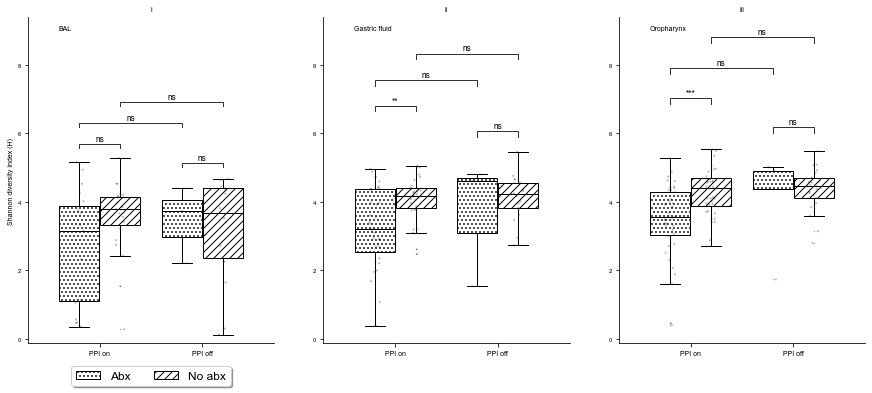

In [11]:
fig = plt.figure(figsize=(15,6))

ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), sharey=ax1)
ax3 = plt.subplot2grid((1, 3), (0, 2), sharey=ax1)


axes = [ax1,ax2,ax3]
sites = ['lung', 'stomach', 'throat']
titles = ['BAL', 'Gastric fluid', 'Oropharynx']
subs = ['i', 'ii', 'iii']

x = 'PPI y/n'
y = 'Shannon diversity index (H)'
hue = 'Abx y/n'
hue_order = ['yes', 'no']
order = ['on', 'off']
palette = ['white', 'white']

abx_no_yaxis = [ax2, ax3]
abx_no_xaxis = [ax1,ax2,ax3]

### Abx plots
for i, ax in enumerate(axes):
    
    data = merge[merge['Swab_site'] == sites[i]]
        
    sns.stripplot(data=data, x=x, y=y ,palette = ['k', 'k'], ax=ax, order=order, hue=hue, hue_order=hue_order,dodge=True, linewidth=0, alpha=0.3, s= 2)
    sns.boxplot(data=data, x=x, y=y, palette = palette, ax=ax, order=order, hue=hue, hue_order=hue_order, linewidth=1, fliersize=0.4)
   
    # Add Wilcoxons rank sum test    
    boxPairList5 = [(('off', 'no'), ('off', 'yes')),
                    (('on', 'no'), ('on', 'yes')),
               (('off', 'yes'), ('on', 'yes')),
               (('off', 'no'), ('on', 'no'))]

    add_stat_annotation(ax, data=data, x=x, y=y, order=order, hue=hue, hue_order=hue_order,
                    box_pairs=boxPairList5,
                    test='Wilcoxon', text_format='star', loc='inside', verbose=2, linewidth=1, fontsize='small', stack=True)

    # Remove legend
    ax.legend_.remove()
    
    # Y axis
    if i in [1,2]:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Shannon diversity index (H)', fontsize=7)
        
    ax.set_xlabel('')
    ax.set_xticklabels(['PPI on', 'PPI off'], fontsize = 7)
    ax.tick_params(axis='y', labelsize=6)
    
    
    # title
    ax.set_title(subs[i], fontsize = 7)
    ax.text(-0.4, 9, titles[i], fontsize=7)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_color('k') 

    # Add patterns to distinuigh boxes
    hatch = [r'...', r'///']
    for i,thisbox in enumerate(ax.artists):
        # Set a different hatch for each bar
        thisbox.set_edgecolor('black')
        if i in [1, 3]:
            thisbox.set_hatch(hatch[1])

        elif i in [0, 2]:
            thisbox.set_hatch(hatch[0])

        # iterate over whiskers and median lines
        for j in range(6*i,6*(i+1)):
             ax.lines[j].set_color('black')
        
        
# Legend
handles, labels = ax1.get_legend_handles_labels()
labels2 = ['Abx', 'No abx']
handles2 = handles[0:2]

yes_patch = mpatches.Patch( facecolor='white',hatch=hatch[0],label=labels2[0], edgecolor='k')
no_patch= mpatches.Patch( facecolor='white',hatch=hatch[1],label=labels2[1], edgecolor='k')



ax1.legend(handles = [yes_patch, no_patch],loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2, fontsize=12)



# ppi

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

yes
['on', 'off'] None
on v.s. off: Wilcoxon test P_val=7.003e-01 U_stat=-3.849e-01
pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

yes
['on', 'off'] None
on v.s. off: Wilcoxon test P_val=8.636e-02 U_stat=-1.715e+00
pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

yes
['on', 'off'] None
on v.s. off: Wilcoxon test P_val=2.168e-02 U_stat=-2.296e+00


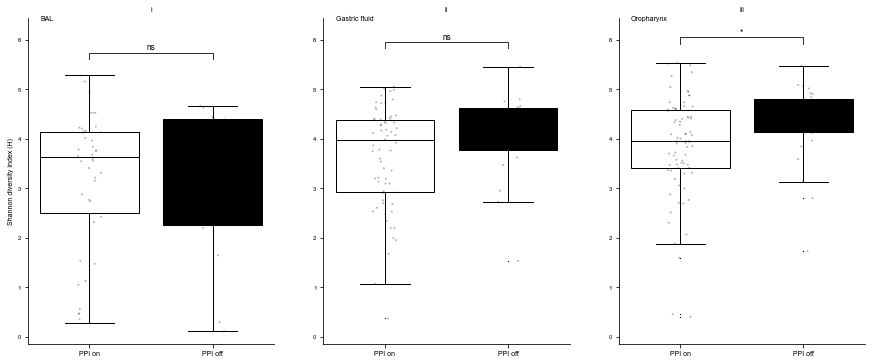

In [13]:
fig = plt.figure(figsize=(15,6))

ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), sharey=ax1)
ax3 = plt.subplot2grid((1, 3), (0, 2), sharey=ax1)


axes = [ax1,ax2,ax3]
sites = ['lung', 'stomach', 'throat']
titles = ['BAL', 'Gastric fluid', 'Oropharynx']
subs = ['i', 'ii', 'iii']

x = 'PPI y/n'
y = 'Shannon diversity index (H)'
order = ['on', 'off']
palette = ['white', 'black']

abx_no_yaxis = [ax2, ax3]
abx_no_xaxis = [ax1,ax2,ax3]

### Abx plots
for i, ax in enumerate(axes):
    
    data = merge[merge['Swab_site'] == sites[i]]
        
    sns.stripplot(data=data, x=x, y=y ,palette = ['k', 'k'], ax=ax, order=order,dodge=True, linewidth=0, alpha=0.3, s= 2)
    sns.boxplot(data=data, x=x, y=y, palette = palette, ax=ax, order=order, linewidth=1, fliersize=0.4)
   
    # Add Wilcoxons rank sum test    
    boxPairList5 = [(('on'), ('off'))]

    add_stat_annotation(ax, data=data, x=x, y=y, order=order, 
                    box_pairs=boxPairList5,
                    test='Wilcoxon', text_format='star', loc='inside', verbose=2, linewidth=1, fontsize='small', stack=True)
   
    # Y axis
    if i in [1,2]:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Shannon diversity index (H)', fontsize=7)
        
    ax.set_xlabel('')
    ax.set_xticklabels(['PPI on', 'PPI off'], fontsize = 7)
    ax.tick_params(axis='y', labelsize=6)
    
    
    # title
    ax.set_title(subs[i], fontsize = 7)
    ax.text(-0.4, 6.4, titles[i], fontsize=7)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_color('k') 


# abx

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

yes
['yes', 'no'] None
yes v.s. no: Wilcoxon test P_val=1.449e-01 U_stat=-1.458e+00
pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

yes
['yes', 'no'] None
yes v.s. no: Wilcoxon test P_val=2.875e-03 U_stat=-2.981e+00
pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

yes
['yes', 'no'] None
yes v.s. no: Wilcoxon test P_val=1.110e-04 U_stat=-3.865e+00


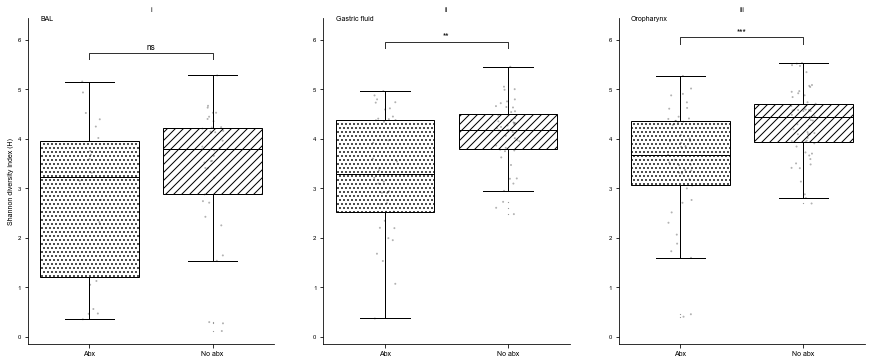

In [14]:
fig = plt.figure(figsize=(15,6))

ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), sharey=ax1)
ax3 = plt.subplot2grid((1, 3), (0, 2), sharey=ax1)


axes = [ax1,ax2,ax3]
sites = ['lung', 'stomach', 'throat']
titles = ['BAL', 'Gastric fluid', 'Oropharynx']
subs = ['i', 'ii', 'iii']

x = 'Abx y/n'
y = 'Shannon diversity index (H)'
order = ['yes', 'no']
palette = ['white', 'white']

abx_no_yaxis = [ax2, ax3]
abx_no_xaxis = [ax1,ax2,ax3]

### Abx plots
for i, ax in enumerate(axes):
    
    data = merge[merge['Swab_site'] == sites[i]]
        
    sns.stripplot(data=data, x=x, y=y ,palette = ['k', 'k'], ax=ax, order=order,dodge=True, linewidth=0, alpha=0.3, s= 2)
    sns.boxplot(data=data, x=x, y=y, palette = palette, ax=ax, order=order, linewidth=1, fliersize=0.4)
   
    # Add Wilcoxons rank sum test    
    boxPairList5 = [(('yes'), ('no'))]

    add_stat_annotation(ax, data=data, x=x, y=y, order=order, 
                    box_pairs=boxPairList5,
                    test='Wilcoxon', text_format='star', loc='inside', verbose=2, linewidth=1, fontsize='small', stack=True)
   
    # Y axis
    if i in [1,2]:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Shannon diversity index (H)', fontsize=7)
        
    ax.set_xlabel('')
    ax.set_xticklabels(['Abx', 'No abx'], fontsize = 7)
    ax.tick_params(axis='y', labelsize=6)
    
    
    # title
    ax.set_title(subs[i], fontsize = 7)
    ax.text(-0.4, 6.4, titles[i], fontsize=7)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_color('k') 
    
        # Add patterns to distinuigh boxes
    hatch = [r'...', r'///']
    for i,thisbox in enumerate(ax.artists):
        # Set a different hatch for each bar
        thisbox.set_edgecolor('black')
        if i in [1, 3]:
            thisbox.set_hatch(hatch[1])

        elif i in [0, 2]:
            thisbox.set_hatch(hatch[0])

        # iterate over whiskers and median lines
        for j in range(6*i,6*(i+1)):
             ax.lines[j].set_color('black')
